## Imports

In [1086]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


## Data Loading

In [1087]:
df_features= pd.read_csv('data/train_features.csv')
df_labels= pd.read_csv('data/train_labels.csv')
df_test= pd.read_csv('data/test_values.csv')
df_submit = pd.read_csv('data/SubmissionFormat.csv')

## EDA And Data Cleaning

Comparing the length of the target and the feature dataframes, if they are the same length as expected, The 2 data frames shall be concatenated so as to clean the data effectively.

In [1088]:
len(df_features) == len(df_labels)

True

In [1089]:
# concatenating the dataframes
df = pd.merge(df_features, df_labels, on='id')
df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


In [1090]:
#inspecting the target variables
df['status_group'].value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

This is ternary classification problem since the target has 3 possible values

## Exploring the data (EDA)


df_features.columns

In [1091]:
df_features.columns

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group'],
      dtype='object')

### The Features in This Dataset

The following set of information about the waterpoints is provided:

- **amount_tsh**: Total static head (amount of water available to the waterpoint)
- **date_recorded**: The date the row was entered
- **funder**: Who funded the well
- **gps_height**: Altitude of the well
- **installer**: Organization that installed the well
- **longitude**: GPS coordinate
- **latitude**: GPS coordinate
- **wpt_name**: Name of the waterpoint, if there is one
- **num_private**: _(Not specified)_
- **basin**: Geographic water basin
- **subvillage**: Geographic location
- **region**: Geographic location
- **region_code**: Geographic location (coded)
- **district_code**: Geographic location (coded)
- **lga**: Geographic location
- **ward**: Geographic location
- **population**: Population around the well
- **public_meeting**: True/False, indicating if a public meeting was held
- **recorded_by**: Group entering this row of data
- **scheme_management**: Who operates the waterpoint
- **scheme_name**: The name of the management scheme
- **permit**: Whether the waterpoint is permitted (True/False)
- **construction_year**: Year the waterpoint was constructed
- **extraction_type**: The kind of extraction method the waterpoint uses
- **extraction_type_group**: The extraction type grouped by similar methods
- **extraction_type_class**: The extraction type categorized into broader classes
- **management**: How the waterpoint is managed
- **management_group**: The management grouped into broader categories
- **payment**: The cost structure of the water
- **payment_type**: The specific type of payment method
- **water_quality**: The quality of the water
- **quality_group**: The quality grouped by similar qualities
- **quantity**: The quantity of water
- **quantity_group**: The quantity grouped by similar quantities
- **source**: The source of the water
- **source_type**: The type of water source
- **source_class**: The broader class of the water source
- **waterpoint_type**: The specific type of waterpoint
- **waterpoint_type_group**: The type of waterpoint grouped by similar types


In [1092]:
df.sample(n=10)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
43382,5194,0.0,2012-10-30,Hesawa,1283,DWE,34.049836,-1.976489,Kwa Kilota,0,...,salty,salty,enough,enough,shallow well,shallow well,groundwater,other,other,non functional
56495,3884,30.0,2013-02-07,Finida German Tanzania Govt,524,Finwater,39.350609,-10.685415,Kwenye Msonobali,0,...,soft,good,insufficient,insufficient,machine dbh,borehole,groundwater,communal standpipe,communal standpipe,functional
53334,55494,50.0,2013-03-20,0,10,0,39.197464,-6.901730,none,0,...,soft,good,enough,enough,machine dbh,borehole,groundwater,communal standpipe,communal standpipe,functional
6796,30006,0.0,2013-02-01,Norad,858,DWE,29.779815,-4.977931,Kanisani Anglican,0,...,soft,good,insufficient,insufficient,river,river/lake,surface,communal standpipe multiple,communal standpipe,functional needs repair
35610,22630,0.0,2011-04-06,NaN,0,NaN,34.378388,-8.767766,Kwa Mzee Chaluta,0,...,soft,good,seasonal,seasonal,river,river/lake,surface,communal standpipe,communal standpipe,functional
28820,18712,10.0,2013-07-03,Germany Republi,1366,CES,37.132144,-3.218196,Area 9 Namba 22,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
55161,74067,1000.0,2011-03-23,Tasaf,486,TASAF,37.727929,-6.803374,Kwa Mwarabu Mpona,0,...,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe,functional
35551,41548,0.0,2012-10-27,World Vision,0,World vision,32.112961,-3.352269,Ilyamchele,0,...,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional
41617,66237,0.0,2011-07-29,Hesawa,0,HESAWA,30.618915,-2.475266,Alimesh,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
54181,48200,1500.0,2011-03-17,Rc,2025,RC,34.590578,-9.280556,Inosi Msigwa,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional


- On inspection, some columns e.g `quantity` and `quantity_group` seem to have identical information. Thus, we first verify if indeed this is the case

In [1093]:
# Check if columns are identical
are_identical = (df['quantity'] == df['quantity_group']).all()

print("Columns are identical:", are_identical)

Columns are identical: True


### Column Inspection Comparison

To streamline our dataset and remove redundancy, we will perform the following steps:

1. **Identify Columns with Similar Names or Descriptions**  
   We'll start by identifying columns that have similar names or descriptions. This helps us determine which columns might contain overlapping information.

2. **Compare Column Content**  
   For columns identified as similar, we will conduct further checks to compare their content. This involves:
   - **Exact Equality Check**: Verifying if the values in the columns are identical for each row.
   - **Handling Missing Values**: Ensuring that missing values are considered in the comparison.
   
3. **Trim Down the Dataset**  
   Based on the comparison results, we will:
   - **Remove Redundant Columns**: Eliminate columns that contain duplicate or redundant information.
   - **Optimize the Dataset**: Reduce the dataset size and complexity by retaining only the necessary columns.

By following these steps, we will improve the quality and efficiency of our dataset, ensuring that we work with clean and relevant data.


In [1094]:
# list to compile all redundant columns to remove on the test dataset as well
redundant_cols = []

In [1095]:
df.columns

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group', 'status_group'],
      dtype='object')

In [1096]:
locations = ['subvillage','region','region_code','district_code','lga','ward']
df[locations].head()

,subvillage,region,region_code,district_code,lga,ward
0,Mnyusi B,Iringa,11,5,Ludewa,Mundindi
1,Nyamara,Mara,20,2,Serengeti,Natta
2,Majengo,Manyara,21,4,Simanjiro,Ngorika
3,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu
4,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi


In [1097]:
df['region_code'].describe()

count    59400.000000
mean        15.297003
std         17.587406
min          1.000000
25%          5.000000
50%         12.000000
75%         17.000000
max         99.000000
Name: region_code, dtype: float64

In [1098]:
for element in locations:
        print(f"Column : {element}, Unique values : {len(df[element].unique())}")

Column : subvillage, Unique values : 19288
Column : region, Unique values : 21
Column : region_code, Unique values : 27
Column : district_code, Unique values : 20
Column : lga, Unique values : 125
Column : ward, Unique values : 2092


## Column Selection for Logistic Regression and Decision Tree Models

### 1. Categorical Variables

- **Decision Trees**: Handle categorical variables well. You can use all categorical columns directly as decision trees can split on different categories without numerical encoding.
  
- **Logistic Regression**: Requires numerical input. Categorical variables need to be encoded into numerical formats, typically using one-hot encoding or label encoding.

### 2. Column Selection

- **`subvillage`**: 19,288 unique values
  - **Note**: High cardinality may make this column challenging to encode and could lead to overfitting. Consider not using it directly.

- **`region`**: 21 unique values
  - **Note**: Moderate number of categories. Can be encoded using one-hot encoding or label encoding.

- **`region_code`**: 27 unique values
  - **Note**: Similar to `region`, this column has a manageable number of categories and can be used after encoding.

- **`district_code`**: 20 unique values
  - **Note**: Manageable number of categories. Suitable for encoding.

- **`lga`**: 125 unique values
  - **Note**: High number of unique values, which may be challenging for encoding and could lead to overfitting.

- **`ward`**: 2,092 unique values
  - **Note**: Very high cardinality, potentially problematic for encoding and may not provide much predictive value.

### Recommendations

- **Decision Trees**: You can use all columns directly. Decision trees handle categorical variables well and can manage high-cardinality features without extensive preprocessing.

- **Logistic Regression**:
  - **Use Columns with Fewer Unique Values**: Start with  `region_code`, `district_code`, and `lga` due to their more manageable number of unique values.
  - **Consider Feature Reduction**: Avoid using `subvillage` and `ward` directly because of their high cardinality. Consider aggregating or grouping these columns to reduce the number of unique values.
  - **One-Hot Encoding**: Apply one-hot encoding for categorical columns that have a manageable number of unique values.


- All this seem to show information about geographical location. From inspection, `district_code` and `region_code` seem to be the most suitable since they are codes of locations and have relatively fewer classes (80 for `district_code`, 100 for `region_code`)

In [1099]:
df_concise = df.drop(['subvillage', 'ward','region'], axis = 1)
df_concise.columns

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'region_code', 'district_code', 'lga', 'population',
       'public_meeting', 'recorded_by', 'scheme_management', 'scheme_name',
       'permit', 'construction_year', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
       'source_class', 'waterpoint_type', 'waterpoint_type_group',
       'status_group'],
      dtype='object')

In [1100]:
redundant_cols += ['subvillage','region','ward']

## We create a function to display relevant info for other similar columns...


In [1101]:
def column_info(similar_cols):
    for element in similar_cols:
        print(f"Column : {element}, Unique values : {len(df[element].unique())}")
    for element in range(len(similar_cols)):
        print (f"Column: {similar_cols[element]}")
        for row in df_concise[similar_cols[element]].unique():
            print(row)
        print('\n')


In [1102]:

#df_concise = df.drop(['subvillage','region','ward'], axis = 1)


Next up...
- **extraction_type**: The kind of extraction method the waterpoint uses
- **extraction_type_group**: The extraction type grouped by similar methods
- **extraction_type_class**: The extraction type categorized into broader classes

In [1103]:
extraction = ['extraction_type','extraction_type_group','extraction_type_class']
column_info(extraction)

Column : extraction_type, Unique values : 18
Column : extraction_type_group, Unique values : 13
Column : extraction_type_class, Unique values : 7
Column: extraction_type
gravity
submersible
swn 80
nira/tanira
india mark ii
other
ksb
mono
windmill
afridev
other - rope pump
india mark iii
other - swn 81
other - play pump
cemo
climax
walimi
other - mkulima/shinyanga


Column: extraction_type_group
gravity
submersible
swn 80
nira/tanira
india mark ii
other
mono
wind-powered
afridev
rope pump
india mark iii
other handpump
other motorpump


Column: extraction_type_class
gravity
submersible
handpump
other
motorpump
wind-powered
rope pump




# IMP
- we settle on `extraction_type_class`


In [1104]:
df_concise = df_concise.drop(['extraction_type','extraction_type_group'], axis = 1)


In [1105]:
redundant_cols += ['extraction_type','extraction_type_group']

Next up...
- **management**: How the waterpoint is managed
- **management_group**: The management grouped into broader categories

In [1106]:
management = ['management','management_group']
column_info(management)

Column : management, Unique values : 12
Column : management_group, Unique values : 5
Column: management
vwc
wug
other
private operator
water board
wua
company
water authority
parastatal
unknown
other - school
trust


Column: management_group
user-group
other
commercial
parastatal
unknown




# IMP
- we settle on `management_group`


In [1107]:
df_concise = df_concise.drop(['management'], axis = 1)
df_concise.columns

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'region_code', 'district_code', 'lga', 'population',
       'public_meeting', 'recorded_by', 'scheme_management', 'scheme_name',
       'permit', 'construction_year', 'extraction_type_class',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
       'source_class', 'waterpoint_type', 'waterpoint_type_group',
       'status_group'],
      dtype='object')

In [1108]:
redundant_cols.append('management')

Next up...
- **payment**: The cost structure of the water
- **payment_type**: The specific type of payment method

In [1109]:
payment = ['payment', 'payment_type']
column_info(payment)
    

Column : payment, Unique values : 7
Column : payment_type, Unique values : 7
Column: payment
pay annually
never pay
pay per bucket
unknown
pay when scheme fails
other
pay monthly


Column: payment_type
annually
never pay
per bucket
unknown
on failure
other
monthly




# IMP
- we settle on `payment_type`


In [1110]:
df_concise = df_concise.drop(['payment'], axis = 1)


In [1111]:
redundant_cols.append('payment')

In [1112]:
df_concise.columns

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'region_code', 'district_code', 'lga', 'population',
       'public_meeting', 'recorded_by', 'scheme_management', 'scheme_name',
       'permit', 'construction_year', 'extraction_type_class',
       'management_group', 'payment_type', 'water_quality', 'quality_group',
       'quantity', 'quantity_group', 'source', 'source_type', 'source_class',
       'waterpoint_type', 'waterpoint_type_group', 'status_group'],
      dtype='object')

Next up...
- **water_quality**: The quality of the water
- **quality_group**: The quality grouped by similar qualities


In [1113]:
water_quality = ['water_quality','quality_group']
column_info(water_quality)

Column : water_quality, Unique values : 8
Column : quality_group, Unique values : 6
Column: water_quality
soft
salty
milky
unknown
fluoride
coloured
salty abandoned
fluoride abandoned


Column: quality_group
good
salty
milky
unknown
fluoride
colored




# IMP
- we settle on `quality_group`


In [1114]:
df_concise = df_concise.drop(['water_quality'], axis = 1)
df_concise.columns

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'region_code', 'district_code', 'lga', 'population',
       'public_meeting', 'recorded_by', 'scheme_management', 'scheme_name',
       'permit', 'construction_year', 'extraction_type_class',
       'management_group', 'payment_type', 'quality_group', 'quantity',
       'quantity_group', 'source', 'source_type', 'source_class',
       'waterpoint_type', 'waterpoint_type_group', 'status_group'],
      dtype='object')

In [1115]:
redundant_cols.append('water_quality')

Next up...
- **quantity**: The quantity of water
- **quantity_group**: The quantity grouped by similar quantities

In [1116]:
water_quanity = ['quantity','quantity_group']
column_info(water_quanity)

Column : quantity, Unique values : 5
Column : quantity_group, Unique values : 5
Column: quantity
enough
insufficient
dry
seasonal
unknown


Column: quantity_group
enough
insufficient
dry
seasonal
unknown




In [1117]:
# Check if columns are identical
are_identical = (df_concise['quantity'] == df_concise['quantity_group']).all()

print("Columns are identical:", are_identical)

Columns are identical: True


# IMP
- we settle on `quantity_group`


In [1118]:
df_concise = df_concise.drop(['quantity'], axis = 1)
df_concise.columns

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'region_code', 'district_code', 'lga', 'population',
       'public_meeting', 'recorded_by', 'scheme_management', 'scheme_name',
       'permit', 'construction_year', 'extraction_type_class',
       'management_group', 'payment_type', 'quality_group', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group', 'status_group'],
      dtype='object')

In [1119]:
redundant_cols.append('quantity')

Next up...
- **source**: The source of the water
- **source_type**: The type of water source
- **source_class**: The broader class of the water source

In [1120]:
source = ['source','source_type','source_class']
column_info(source)

Column : source, Unique values : 10
Column : source_type, Unique values : 7
Column : source_class, Unique values : 3
Column: source
spring
rainwater harvesting
dam
machine dbh
other
shallow well
river
hand dtw
lake
unknown


Column: source_type
spring
rainwater harvesting
dam
borehole
other
shallow well
river/lake


Column: source_class
groundwater
surface
unknown




### Recommendation for Dropping Columns

- **Drop `source`**: Since `source` contains the most detailed level of information and has the highest number of unique values, it could introduce more complexity without adding significant predictive power compared to `source_type`. The fine granularity may also lead to overfitting, especially in logistic regression.

- **Keep `source_class`**: This column has the least number of unique values, making it simple to encode and interpret. It provides high-level, general information that could be useful for both logistic regression and decision trees without adding much complexity.

- **Keep `source_type`**: This column offers a balance between detail and simplicity with 7 unique values. It provides more information than `source_class` but is less granular than `source`. This could be useful depending on the specific needs of your model.

### Final Recommendations

- **For Decision Trees**: Keep both `source_class` and `source_type`. Decision trees handle categorical variables well, and having both columns could help the model learn from both general and more specific information.

- **For Logistic Regression**: Drop `source` and use `source_class` and `source_type`. These two columns are simpler to encode and reduce the risk of multicollinearity and overfitting due to fewer unique values.


In [1121]:
df_concise = df_concise.drop(['source'], axis = 1)
df_concise.columns

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'region_code', 'district_code', 'lga', 'population',
       'public_meeting', 'recorded_by', 'scheme_management', 'scheme_name',
       'permit', 'construction_year', 'extraction_type_class',
       'management_group', 'payment_type', 'quality_group', 'quantity_group',
       'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group', 'status_group'],
      dtype='object')

In [1122]:
redundant_cols.append('source')

Next up...
- **waterpoint_type**: The specific type of waterpoint
- **waterpoint_type_group**: The type of waterpoint grouped by similar types


In [1123]:
waterpoint = ['waterpoint_type','waterpoint_type_group']
column_info(waterpoint)

Column : waterpoint_type, Unique values : 7
Column : waterpoint_type_group, Unique values : 6
Column: waterpoint_type
communal standpipe
communal standpipe multiple
hand pump
other
improved spring
cattle trough
dam


Column: waterpoint_type_group
communal standpipe
hand pump
other
improved spring
cattle trough
dam




# IMP
- we settle on `waterpoint_type_group`


In [1124]:
df_concise = df_concise.drop(['waterpoint_type'], axis = 1)
df_concise.columns

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'region_code', 'district_code', 'lga', 'population',
       'public_meeting', 'recorded_by', 'scheme_management', 'scheme_name',
       'permit', 'construction_year', 'extraction_type_class',
       'management_group', 'payment_type', 'quality_group', 'quantity_group',
       'source_type', 'source_class', 'waterpoint_type_group', 'status_group'],
      dtype='object')

In [1125]:
redundant_cols.append('waterpoint_type')

In [1126]:
len(df_concise.columns)

30

In [1127]:
df_concise.columns

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'region_code', 'district_code', 'lga', 'population',
       'public_meeting', 'recorded_by', 'scheme_management', 'scheme_name',
       'permit', 'construction_year', 'extraction_type_class',
       'management_group', 'payment_type', 'quality_group', 'quantity_group',
       'source_type', 'source_class', 'waterpoint_type_group', 'status_group'],
      dtype='object')

Ascertaining that all redundant columns dropped have been captured


In [1128]:
len(df_concise.columns) == (len(df.columns)- len(redundant_cols))

True

In [1129]:
redundant_cols

['subvillage',
 'region',
 'ward',
 'extraction_type',
 'extraction_type_group',
 'management',
 'payment',
 'water_quality',
 'quantity',
 'source',
 'waterpoint_type']

In [1130]:
df_concise.columns

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'region_code', 'district_code', 'lga', 'population',
       'public_meeting', 'recorded_by', 'scheme_management', 'scheme_name',
       'permit', 'construction_year', 'extraction_type_class',
       'management_group', 'payment_type', 'quality_group', 'quantity_group',
       'source_type', 'source_class', 'waterpoint_type_group', 'status_group'],
      dtype='object')

# The Features in This Dataset

The following features are left after extracting redundant columns:


- `amount_tsh`: Total static head (amount of water available to the waterpoint)
- `date_recorded`: The date the row was entered
- `funder`: Who funded the well
- `gps_height`: Altitude of the well
- `installer`: Organization that installed the well
- `longitude`: GPS coordinate
- `latitude`: GPS coordinate
- `wpt_name`: Name of the waterpoint, if there is one
- `num_private`: _(Not specified)_
- `basin`: Geographic water basin
- `region_code`: Geographic location (coded)
- `district_code`: Geographic location (coded)
- `lga`: ( Geographic location )- Local Government Authorities (LGAs) in Tanzania are accountable for the delivery of public services to citizens - providing 
oversight and management support to health facilities, schools, and villages.
- `population`: Population around the well
- `public_meeting`: True/False, indicating if a public meeting was held
- `recorded_by`: Group entering this row of data
- `scheme_management`: Who operates the waterpoint
- `scheme_name`: The name of the management scheme
- `permit`: Whether the waterpoint is permitted (True/False)
- `construction_year`: Year the waterpoint was constructed
- `extraction_type_class`: The extraction type categorized into broader classes
- `management_group`: The management grouped into broader categories
- `payment_type`: The specific type of payment method
- `quality_group`: The quality grouped by similar qualities
- `quantity_group`: The quantity grouped by similar quantities
- `source_type`: The type of water source
- `source_class`: The broader class of the water source
- `waterpoint_type_group`: The type of waterpoint grouped by similar types


## Data Cleaning- Extracting unnecessary columns with little useful info


From Domain Knowledge, the following columns can be dropped
- date_recorded
- longitude
- latitude
- wpt_name
- num_private
- recorded_by

In [1131]:
unncecessary_cols = [ 'date_recorded','longitude','latitude','wpt_name','num_private','recorded_by']
df_concise = df_concise.drop(unncecessary_cols, axis = 1)
df_concise.columns

Index(['id', 'amount_tsh', 'funder', 'gps_height', 'installer', 'basin',
       'region_code', 'district_code', 'lga', 'population', 'public_meeting',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type_class', 'management_group', 'payment_type',
       'quality_group', 'quantity_group', 'source_type', 'source_class',
       'waterpoint_type_group', 'status_group'],
      dtype='object')

In [1132]:
len(df_concise.columns)

24

-inspecting the other columns to check whether other columns can be dropped

In [1133]:
for element in df_concise.columns:
        print(f"Column : {element}, Unique values : {len(df[element].unique())}")

Column : id, Unique values : 59400
Column : amount_tsh, Unique values : 98
Column : funder, Unique values : 1898
Column : gps_height, Unique values : 2428
Column : installer, Unique values : 2146
Column : basin, Unique values : 9
Column : region_code, Unique values : 27
Column : district_code, Unique values : 20
Column : lga, Unique values : 125
Column : population, Unique values : 1049
Column : public_meeting, Unique values : 3
Column : scheme_management, Unique values : 13
Column : scheme_name, Unique values : 2697
Column : permit, Unique values : 3
Column : construction_year, Unique values : 55
Column : extraction_type_class, Unique values : 7
Column : management_group, Unique values : 5
Column : payment_type, Unique values : 7
Column : quality_group, Unique values : 6
Column : quantity_group, Unique values : 5
Column : source_type, Unique values : 7
Column : source_class, Unique values : 3
Column : waterpoint_type_group, Unique values : 6
Column : status_group, Unique values : 3


from above, the features : installer, scheme_management, scheme_name,funder seem to be extraneous so we shall inspect them

In [1134]:
possible_extraneous = ['installer', 'scheme_management', 'scheme_name','funder']
for element in possible_extraneous:
    print (df_concise[element].sample(n=10))

39265           DWE
43421            DW
42626           DWE
8447            DWE
8564     Government
34838           DWE
58938             0
36706         MDRDP
44373           DWE
1394          Local
Name: installer, dtype: object
8387     VWC
26056    NaN
25005    NaN
5879     VWC
39493    VWC
25002    VWC
49282    VWC
4136     VWC
51232    VWC
47581    WUG
Name: scheme_management, dtype: object
54717                   Nyasovu
17516    Losaa Kia water supply
43986                     Japan
1547                        NaN
7670                          K
30682                         S
26709                         M
41892                       MWS
53406                       NaN
58489                Fini water
Name: scheme_name, dtype: object
16048    Government Of Tanzania
29462    Government Of Tanzania
3981                     Hesawa
23465                     Shipo
45880                      Kidp
44178                        Go
28602                  Irish Ai
17790                  

ALl this info, on further inspection, are extraneous, therefore we shall drop them too


In [1135]:
# add `possible_extraneous` to unnecessary cols and drop
unncecessary_cols += possible_extraneous
df_concise = df_concise.drop(possible_extraneous, axis = 1)
df_concise.columns

Index(['id', 'amount_tsh', 'gps_height', 'basin', 'region_code',
       'district_code', 'lga', 'population', 'public_meeting', 'permit',
       'construction_year', 'extraction_type_class', 'management_group',
       'payment_type', 'quality_group', 'quantity_group', 'source_type',
       'source_class', 'waterpoint_type_group', 'status_group'],
      dtype='object')

### **At this juncture, we have dropped the unncecessary and redundant columns. Next we shall deal with missing values, if present**

- Verifying the above...


In [1136]:
(len(df.columns)- len(df_concise.columns)) == (len(redundant_cols) + len(unncecessary_cols))

True

### **Dealing with missing values**

In [1137]:
df_concise.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   gps_height             59400 non-null  int64  
 3   basin                  59400 non-null  object 
 4   region_code            59400 non-null  int64  
 5   district_code          59400 non-null  int64  
 6   lga                    59400 non-null  object 
 7   population             59400 non-null  int64  
 8   public_meeting         56066 non-null  object 
 9   permit                 56344 non-null  object 
 10  construction_year      59400 non-null  int64  
 11  extraction_type_class  59400 non-null  object 
 12  management_group       59400 non-null  object 
 13  payment_type           59400 non-null  object 
 14  quality_group          59400 non-null  object 
 15  qu

- From earlier inspection, several numeric columns contain zeros where they are unrealistic. We shall convert them to NaNs so as to simplify the process of filling them.first we feature engineer age column from construction year

## Feature Engineering
We shall replace construction year with age as ,from domain knowledge, we expect proportionality between target and the feature

In [1138]:
# Calculate age where year is not equal to 0
df_concise.loc[df_concise['construction_year'] != 0, 'age'] = 2024 - df['construction_year']

In [1139]:
df_concise = df_concise.drop(['construction_year'], axis = 1 )
df_concise.columns

Index(['id', 'amount_tsh', 'gps_height', 'basin', 'region_code',
       'district_code', 'lga', 'population', 'public_meeting', 'permit',
       'extraction_type_class', 'management_group', 'payment_type',
       'quality_group', 'quantity_group', 'source_type', 'source_class',
       'waterpoint_type_group', 'status_group', 'age'],
      dtype='object')

In [1140]:
df_concise.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   gps_height             59400 non-null  int64  
 3   basin                  59400 non-null  object 
 4   region_code            59400 non-null  int64  
 5   district_code          59400 non-null  int64  
 6   lga                    59400 non-null  object 
 7   population             59400 non-null  int64  
 8   public_meeting         56066 non-null  object 
 9   permit                 56344 non-null  object 
 10  extraction_type_class  59400 non-null  object 
 11  management_group       59400 non-null  object 
 12  payment_type           59400 non-null  object 
 13  quality_group          59400 non-null  object 
 14  quantity_group         59400 non-null  object 
 15  so

- From general info, it seems NaN's are only present in the  columns  `public_meeting` and `permit`,However, on converting zeros to NaNs there may be more, first let's convert the above 2

In [1141]:
df_concise['public_meeting'].value_counts(), df_concise['permit'].value_counts()

(True     51011
 False     5055
 Name: public_meeting, dtype: int64,
 True     38852
 False    17492
 Name: permit, dtype: int64)

In [1142]:
df_concise['public_meeting'].isna().sum(), df_concise['permit'].isna().sum(), 

(3334, 3056)

Represent small % of data so we shall fill them with the most frequent, being true

In [1143]:
#Replacing 'True and False with zero and one resp
df_concise['public_meeting'] = df_concise['public_meeting'].replace({True: 1, False: 0})
df_concise['permit'] = df_concise['permit'].replace({True: 1, False: 0})
df_concise.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   gps_height             59400 non-null  int64  
 3   basin                  59400 non-null  object 
 4   region_code            59400 non-null  int64  
 5   district_code          59400 non-null  int64  
 6   lga                    59400 non-null  object 
 7   population             59400 non-null  int64  
 8   public_meeting         56066 non-null  float64
 9   permit                 56344 non-null  float64
 10  extraction_type_class  59400 non-null  object 
 11  management_group       59400 non-null  object 
 12  payment_type           59400 non-null  object 
 13  quality_group          59400 non-null  object 
 14  quantity_group         59400 non-null  object 
 15  so

In [1144]:
#fill nans with most frequent, in this case '1'
df_concise['public_meeting'].fillna(1, inplace= True)
df_concise['permit'].fillna(1, inplace= True)

df_concise .info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   gps_height             59400 non-null  int64  
 3   basin                  59400 non-null  object 
 4   region_code            59400 non-null  int64  
 5   district_code          59400 non-null  int64  
 6   lga                    59400 non-null  object 
 7   population             59400 non-null  int64  
 8   public_meeting         59400 non-null  float64
 9   permit                 59400 non-null  float64
 10  extraction_type_class  59400 non-null  object 
 11  management_group       59400 non-null  object 
 12  payment_type           59400 non-null  object 
 13  quality_group          59400 non-null  object 
 14  quantity_group         59400 non-null  object 
 15  so

- Verify that changes were done 

In [1145]:
df_concise['public_meeting'].value_counts(), df_concise['permit'].value_counts()

(1.0    54345
 0.0     5055
 Name: public_meeting, dtype: int64,
 1.0    41908
 0.0    17492
 Name: permit, dtype: int64)

In [1146]:
df_concise['public_meeting'] .isna().sum()

0

Now converting zeros to NaNs in the remaining numeric cols, we shall drop amount_tsh, since zeros account for 70.1 % of the data


In [1147]:
df_concise = df_concise.drop(columns=['amount_tsh'], axis = 1)
unncecessary_cols.append('amount_tsh')
unncecessary_cols

['date_recorded',
 'longitude',
 'latitude',
 'wpt_name',
 'num_private',
 'recorded_by',
 'installer',
 'scheme_management',
 'scheme_name',
 'funder',
 'amount_tsh']

In [1148]:
numeric_cols = ['age','region_code','district_code','population','gps_height']


In [1149]:
for col in numeric_cols:
    print(f"column : {col}. Zero Count : {len(df_concise[df_concise[col]==0])}. Mean: {df_concise[col].mean()}, Mode: {df_concise[col].mode()}, Median: {df_concise[col].median()} ")

column : age. Zero Count : 0. Mean: 27.185314414204854, Mode: 0    14.0
dtype: float64, Median: 24.0 
column : region_code. Zero Count : 0. Mean: 15.297003367003366, Mode: 0    11
dtype: int64, Median: 12.0 
column : district_code. Zero Count : 23. Mean: 5.629747474747475, Mode: 0    1
dtype: int64, Median: 3.0 
column : population. Zero Count : 21381. Mean: 179.90998316498317, Mode: 0    0
dtype: int64, Median: 25.0 
column : gps_height. Zero Count : 20438. Mean: 668.297239057239, Mode: 0    0
dtype: int64, Median: 369.0 


In [1150]:
len(df_concise[df_concise['population']==30]),len(df_concise[df_concise['population']==150]),

(626, 1892)

Also converting 1's in population to median seince they are not practical

For this study, the value of population = 1 may not make much practical sense, especially when considering waterpoints, as it is highly unlikely that a waterpoint would serve only one person. Here’s a structured approach to handle the situation:

Replace population = 1 with the Median:
Replacing these with the median makes the data more realistic and ensures that it represents typical values without skewing the distribution with improbable data points.

In [1151]:
# Calculate the median of the 'population' column excluding 1
median_population = df_concise[df['population'] != 1]['population'].median()

# Replace values of 1 in the 'population' column with the median
df_concise['population'] = df_concise['population'].replace(1, median_population)


In [1152]:
for col in numeric_cols:
    # Convert zero values to NaN in the 'gps_height' column
    df_concise[col] = df_concise[col].replace(0, np.nan)

In [1153]:
df_concise.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   gps_height             38962 non-null  float64
 2   basin                  59400 non-null  object 
 3   region_code            59400 non-null  int64  
 4   district_code          59377 non-null  float64
 5   lga                    59400 non-null  object 
 6   population             38019 non-null  float64
 7   public_meeting         59400 non-null  float64
 8   permit                 59400 non-null  float64
 9   extraction_type_class  59400 non-null  object 
 10  management_group       59400 non-null  object 
 11  payment_type           59400 non-null  object 
 12  quality_group          59400 non-null  object 
 13  quantity_group         59400 non-null  object 
 14  source_type            59400 non-null  object 
 15  so

In [1154]:
numeric_cols

['age', 'region_code', 'district_code', 'population', 'gps_height']

In [1155]:
for col in numeric_cols:
    print(f"column : {col}.Mean: {df_concise[col].mean()}, Mode: {df_concise[col].mode()}, Median: {df_concise[col].median()} ")

column : age.Mean: 27.185314414204854, Mode: 0    14.0
dtype: float64, Median: 24.0 
column : region_code.Mean: 15.297003367003366, Mode: 0    11
dtype: int64, Median: 12.0 
column : district_code.Mean: 5.6319281876820995, Mode: 0    1.0
dtype: float64, Median: 3.0 
column : population.Mean: 291.9889528919751, Mode: 0    60.0
dtype: float64, Median: 150.0 
column : gps_height.Mean: 1018.8608387659771, Mode: 0   -15.0
dtype: float64, Median: 1167.0 


In [1156]:
df_concise.describe()

,id,gps_height,region_code,district_code,population,public_meeting,permit,age
count,59400.000000,38962.000000,59400.000000,59377.000000,38019.000000,59400.000000,59400.000000,38691.000000
mean,37115.131768,1018.860839,15.297003,5.631928,291.988953,0.914899,0.705522,27.185314
std,21453.128371,612.566092,17.587406,9.634877,559.722665,0.279034,0.455812,12.472045
min,0.000000,-90.000000,1.000000,1.000000,2.000000,0.000000,0.000000,11.000000
25%,18519.750000,393.000000,5.000000,2.000000,60.000000,1.000000,0.000000,16.000000
50%,37061.500000,1167.000000,12.000000,3.000000,150.000000,1.000000,1.000000,24.000000
75%,55656.500000,1498.000000,17.000000,5.000000,324.000000,1.000000,1.000000,37.000000
max,74247.000000,2770.000000,99.000000,80.000000,30500.000000,1.000000,1.000000,64.000000


# IMP

-For the numeric columns except district_code and region_code, we shall fill with the average value


In [1157]:
numeric_cols_fillna_average = ['age', 'population', 'gps_height']
for col in numeric_cols_fillna_average:
    #fill nans with median
    df_concise[col].fillna(df_concise[col].median(), inplace= True)
    

df_concise .info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   gps_height             59400 non-null  float64
 2   basin                  59400 non-null  object 
 3   region_code            59400 non-null  int64  
 4   district_code          59377 non-null  float64
 5   lga                    59400 non-null  object 
 6   population             59400 non-null  float64
 7   public_meeting         59400 non-null  float64
 8   permit                 59400 non-null  float64
 9   extraction_type_class  59400 non-null  object 
 10  management_group       59400 non-null  object 
 11  payment_type           59400 non-null  object 
 12  quality_group          59400 non-null  object 
 13  quantity_group         59400 non-null  object 
 14  source_type            59400 non-null  object 
 15  so

for the district code, I shall fill NaNs with the most frequent that occurred in its associated region, since region has no NaNs

In [1158]:
# Fill NaNs with the most frequent district_code within each region_code
df_concise['district_code'] = df_concise.groupby('region_code')['district_code'].transform(
    lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan)
)

In [1159]:
df_concise .info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   gps_height             59400 non-null  float64
 2   basin                  59400 non-null  object 
 3   region_code            59400 non-null  int64  
 4   district_code          59400 non-null  float64
 5   lga                    59400 non-null  object 
 6   population             59400 non-null  float64
 7   public_meeting         59400 non-null  float64
 8   permit                 59400 non-null  float64
 9   extraction_type_class  59400 non-null  object 
 10  management_group       59400 non-null  object 
 11  payment_type           59400 non-null  object 
 12  quality_group          59400 non-null  object 
 13  quantity_group         59400 non-null  object 
 14  source_type            59400 non-null  object 
 15  so

## Checking for Outliers

For our project, we shall remove outliers from columns with high variablity. We shall proceed with 2 datasets from hence forth,one with outliers, one without, since the the different models we try out might have diff performances with them

In [1160]:
df_concise.columns, df_concise.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   gps_height             59400 non-null  float64
 2   basin                  59400 non-null  object 
 3   region_code            59400 non-null  int64  
 4   district_code          59400 non-null  float64
 5   lga                    59400 non-null  object 
 6   population             59400 non-null  float64
 7   public_meeting         59400 non-null  float64
 8   permit                 59400 non-null  float64
 9   extraction_type_class  59400 non-null  object 
 10  management_group       59400 non-null  object 
 11  payment_type           59400 non-null  object 
 12  quality_group          59400 non-null  object 
 13  quantity_group         59400 non-null  object 
 14  source_type            59400 non-null  object 
 15  so

(Index(['id', 'gps_height', 'basin', 'region_code', 'district_code', 'lga',
        'population', 'public_meeting', 'permit', 'extraction_type_class',
        'management_group', 'payment_type', 'quality_group', 'quantity_group',
        'source_type', 'source_class', 'waterpoint_type_group', 'status_group',
        'age'],
       dtype='object'),
 None)

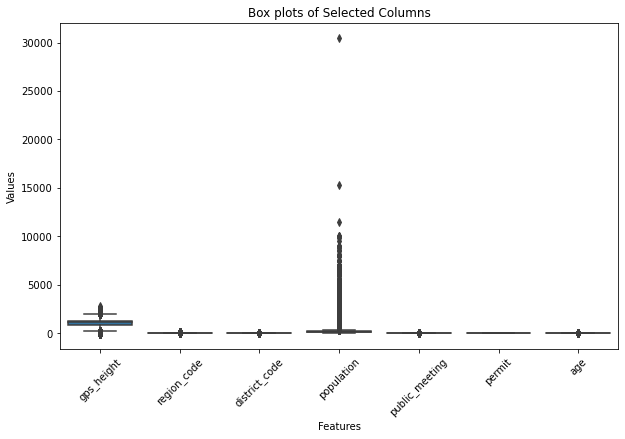

In [1171]:
# Plotting box plots for each column
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_concise.iloc[:,1:])
plt.title('Box plots of Selected Columns')
plt.xlabel('Features')
plt.ylabel('Values')
plt.xticks(rotation=45)
plt.show()

### Removing outliers of pop, IMP...

In [1162]:
df_concise.describe()

,id,gps_height,region_code,district_code,population,public_meeting,permit,age
count,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,1069.831684,15.297003,5.630135,240.880101,0.914899,0.705522,26.074798
std,21453.128371,501.077319,17.587406,9.633442,452.950368,0.279034,0.455812,10.179591
min,0.000000,-90.000000,1.000000,1.000000,2.000000,0.000000,0.000000,11.000000
25%,18519.750000,903.000000,5.000000,2.000000,100.000000,1.000000,0.000000,20.000000
50%,37061.500000,1167.000000,12.000000,3.000000,150.000000,1.000000,1.000000,24.000000
75%,55656.500000,1319.250000,17.000000,5.000000,215.000000,1.000000,1.000000,28.000000
max,74247.000000,2770.000000,99.000000,80.000000,30500.000000,1.000000,1.000000,64.000000


In [1163]:
df_selected_outliers = df_concise[['population']]


# Calculate IQR for selected columns
Q1 = df_selected_outliers.quantile(0.25)
Q3 = df_selected_outliers.quantile(0.75)
IQR = Q3 - Q1

# Define outlier boundaries
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Find outliers
outliers = ((df_selected_outliers< lower_bound) | (df_selected_outliers > upper_bound)).any(axis=1)

# Print indices of outliers
outlier_indices = df.index[outliers]

In [1164]:
# droping all rows with outliers 
df_concise_without_outliers = df_concise.drop(outlier_indices)
df_concise.info(),df_concise_without_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   gps_height             59400 non-null  float64
 2   basin                  59400 non-null  object 
 3   region_code            59400 non-null  int64  
 4   district_code          59400 non-null  float64
 5   lga                    59400 non-null  object 
 6   population             59400 non-null  float64
 7   public_meeting         59400 non-null  float64
 8   permit                 59400 non-null  float64
 9   extraction_type_class  59400 non-null  object 
 10  management_group       59400 non-null  object 
 11  payment_type           59400 non-null  object 
 12  quality_group          59400 non-null  object 
 13  quantity_group         59400 non-null  object 
 14  source_type            59400 non-null  object 
 15  so

(None, None)

Now we have clean data

# Data Preprocessing

## Declaring Target and Features


In [1165]:
df_concise.columns

Index(['id', 'gps_height', 'basin', 'region_code', 'district_code', 'lga',
       'population', 'public_meeting', 'permit', 'extraction_type_class',
       'management_group', 'payment_type', 'quality_group', 'quantity_group',
       'source_type', 'source_class', 'waterpoint_type_group', 'status_group',
       'age'],
      dtype='object')

In [1180]:
X_1 = df_concise.drop(['status_group'], axis=1)
X_2 = df_concise_without_outliers.drop(['status_group'], axis=1)

y_1 = df_concise['status_group']
y_2 = df_concise_without_outliers['status_group']

### Expound on the meanings of 1 and 2